## Import relevant libraries. (json, sklearn, pandas and numpy )

In [1]:
import json,string
import pandas as pd
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import *
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
%matplotlib inline

##  Read and extract data from json file

- We can use json library along with a recursive function that expands nested values in json format. 
- The clean data is then stored in a pandas dataframe

In [2]:
res=[]
with open('posts.json') as f:
    for line in f.readlines():
        res.append({"":json.loads(line.replace("["," ").replace("]"," "))})


In [3]:
from functools import reduce

def _flatten_reducer(dict_, key, val, prefix):
    if isinstance(val, (dict,list)):
        return {**flatten(val, prefix + key), **dict_}
    else:
        return {prefix + key: val, **dict_}


def flatten(dict_, prefix=''):
    # flatten nested dicts
    return reduce(
        lambda new_dict, cur_kv: _flatten_reducer(new_dict, *cur_kv, prefix),
        dict_.items(),
        {}
    )

In [4]:
data = pd.DataFrame([flatten(res[i]) for i in range(len(res))])

In [5]:
pd.set_option("display.max_rows",400)
data.T.iloc[:,0:5].to_csv('sample.csv')

In [6]:
data.head()

,caption,created_time,description,feed_targetingreach_estimate,id,insightspost_consumptions_by_type_uniquedescription,insightspost_consumptions_by_type_uniqueid,insightspost_consumptions_by_type_uniquename,insightspost_consumptions_by_type_uniqueperiod,insightspost_consumptions_by_type_uniquetitle,...,insightspost_video_viewsname,insightspost_video_viewsperiod,insightspost_video_viewstitle,insightspost_video_viewsvaluesvalue,link,link_to_post,message,name,picture,story
0,komonews.com,2015-09-17T20:50:00+0000,About 20 western Virginia high school students...,NaN,114431401958534_940695755998757,Lifetime: The number of people who clicked any...,114431401958534_940695755998757/insights/post_...,post_consumptions_by_type_unique,lifetime,Lifetime Post consumers by type,...,post_video_views,lifetime,Lifetime Total Video Views,0.0,http://www.komonews.com/news/national/Students...,http://facebook.com/114431401958534_9406957559...,Do you think the Confederate flag should be ba...,Students suspended for clothing displaying Con...,https://external.xx.fbcdn.net/safe_image.php?d...,NaN
1,NaN,2015-09-17T20:20:01+0000,NaN,NaN,114431401958534_940684872666512,Lifetime: The number of people who clicked any...,114431401958534_940684872666512/insights/post_...,post_consumptions_by_type_unique,lifetime,Lifetime Post consumers by type,...,NaN,NaN,NaN,NaN,https://www.facebook.com/KOMONews/photos/a.121...,http://facebook.com/114431401958534_9406848726...,Seattle Seahawks' Russell Wilson answered lots...,Timeline Photos,https://fbcdn-photos-b-a.akamaihd.net/hphotos-...,NaN
2,komonews.com,2015-09-17T19:49:28+0000,Despite September looking like it will break o...,NaN,114431401958534_940684229333243,Lifetime: The number of people who clicked any...,114431401958534_940684229333243/insights/post_...,post_consumptions_by_type_unique,lifetime,Lifetime Post consumers by type,...,post_video_views,lifetime,Lifetime Total Video Views,0.0,http://www.komonews.com/weather/blogs/scott/Ne...,http://facebook.com/114431401958534_9406842293...,"It'll be a bummer for snow lovers, but warm-we...","New forecasts still say mild winter, hot summe...",https://external.xx.fbcdn.net/safe_image.php?d...,NaN
3,komonews.com,2015-09-17T19:18:00+0000,Amazon is dangling a $50 tablet computer in it...,NaN,114431401958534_940637569337909,Lifetime: The number of people who clicked any...,114431401958534_940637569337909/insights/post_...,post_consumptions_by_type_unique,lifetime,Lifetime Post consumers by type,...,post_video_views,lifetime,Lifetime Total Video Views,0.0,http://www.komonews.com/news/tech/Amazon-dangl...,http://facebook.com/114431401958534_9406375693...,What do you think of Amazon's cheaper tablet?,Amazon dangles $50 tablet computer to hook mor...,https://fbexternal-a.akamaihd.net/safe_image.p...,NaN
4,komonews.com,2015-09-17T18:45:00+0000,Earth's record-breaking heat is sounding an aw...,NaN,114431401958534_940535546014778,Lifetime: The number of people who clicked any...,114431401958534_940535546014778/insights/post_...,post_consumptions_by_type_unique,lifetime,Lifetime Post consumers by type,...,post_video_views,lifetime,Lifetime Total Video Views,0.0,http://www.komonews.com/news/national/Earths-r...,http://facebook.com/114431401958534_9405355460...,Meteorologists say 2015 is a near certainty to...,Earth's record streak of record heat keeps on ...,https://external.xx.fbcdn.net/safe_image.php?d...,NaN


In [7]:
# selected features for analysis
features = ['description','insightspost_impressionsvaluesvalue','insightspost_negative_feedbackvaluesvalue',
            'insightspost_storiesvaluesvalue','insightspost_storytellers_by_action_typevaluesvaluecomment',
            'insightspost_storytellers_by_action_typevaluesvaluelike','insightspost_storytellers_by_action_typevaluesvalueshare',
            'insightspost_consumptionsvaluesvalue','message','name','caption','created_time','id']
data1 = data[features]

In [8]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8639 entries, 0 to 8638
Data columns (total 13 columns):
description                                                   4573 non-null object
insightspost_impressionsvaluesvalue                           8639 non-null int64
insightspost_negative_feedbackvaluesvalue                     8639 non-null int64
insightspost_storiesvaluesvalue                               8639 non-null int64
insightspost_storytellers_by_action_typevaluesvaluecomment    8499 non-null float64
insightspost_storytellers_by_action_typevaluesvaluelike       8547 non-null float64
insightspost_storytellers_by_action_typevaluesvalueshare      8393 non-null float64
insightspost_consumptionsvaluesvalue                          8639 non-null int64
message                                                       8538 non-null object
name                                                          7381 non-null object
caption                                                       53

## Handling missing values
- We can drop the rows with missing metric values and fill the text fields with an empty string.

In [9]:
cat, num =[],[]
for c in data1.columns:
    if data1[c].dtype=="object":
        cat.append(c)
        data1.loc[:,c].fillna(value="",inplace=True)
    else:
        num.append(c)


/Users/alizaf/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [10]:
data1 = data1[~data1[num].isnull().any(axis=1)]

## Combine all text columns.
This might help with hihglighting repeated words in word vectorizer. 

In [11]:
data1['text'] = data1[['description','message','name']].apply(lambda x: " ".join(x),axis=1)

## Selecting Target Metric:
 
 - I have selected click through rate for this brief study, as it provides insight to ratio of clicks out of total impressions. 
 - As described bellow, a log transform can make our target data much closer to a normal shape, which is in general more suitable for Mean Square Error (MSE). 

In [12]:
data1['CTR'] = np.divide(data1.loc[:,'insightspost_consumptionsvaluesvalue'],data1.loc[:,'insightspost_impressionsvaluesvalue'])

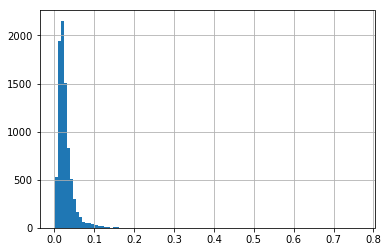

In [13]:
data1.CTR.hist(bins=100)

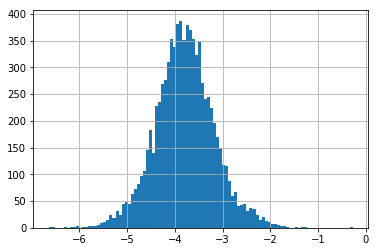

In [14]:
data1['CTR_log'] = data1.CTR.apply(lambda x:np.log(x))
data1['CTR_log'] .hist(bins=100)

- Note that standard deviation is 0.62. This is the maximum error our model can have to add any value. 

In [15]:
data1.CTR_log.describe()

count    8356.000000
mean       -3.793492
std         0.620054
min        -6.648539
25%        -4.181847
50%        -3.800854
75%        -3.413726
max        -0.268543
Name: CTR_log, dtype: float64

- Train/ Test split is the next step. We perform cross validation on train data and save test data for final scoring. 

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(data1.text.values, data1.CTR_log, 
                                                  random_state=42, 
                                                  test_size=0.25)

# NLP:
- TF-IDF and Count Vectorizer are tested for quantifying text data. We try to predict results only relying on these data. Other meta data such as datetime, frequency of posts etc. are arguably effective to include in model which we skip them in this brief analysis. 

In [17]:
def get_vec_pipe(num_comp=0, vect='tfv', reducer='svd'):
# Create text vectorization pipeline with optional dimensionality reduction.
    # Vectorizer
    vec_pipe = []
    if vect == 'tfv':
        tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
        vec_pipe.append(('vec', tfv))
    else:
        ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')
        vec_pipe.append(('vec', ctv))
    
    # Reduce dimensions
    if num_comp > 0:
        if reducer == 'svd':
            vec_pipe.append(('dim_red', TruncatedSVD(num_comp)))
        elif reducer == 'kbest':
            vec_pipe.append(('dim_red', SelectKBest(chi2, k=num_comp)))
        elif reducer == 'percentile':
            vec_pipe.append(('dim_red', SelectPercentile(f_classif, percentile=num_comp)))

        vec_pipe.append(('norm', Normalizer()))
    return Pipeline(vec_pipe)

In [18]:
# CTV
# ncomp is temporarily set as 200. we will tune it in following sections. Liniear regression is selected as a starting point. 
ncomp=200
full_pipeline = Pipeline([
        ("preparation", get_vec_pipe(ncomp,vect="ctv")),
        ("linear", LinearRegression())
    ])


scores_ctv = cross_val_score(full_pipeline, xtrain, ytrain, scoring="neg_mean_squared_error", cv=5)
pd.Series(np.sqrt(-scores_ctv)).describe()

count    5.000000
mean     0.531489
std      0.013668
min      0.512338
25%      0.527388
50%      0.528245
75%      0.543692
max      0.545782
dtype: float64

In [20]:
#TFV
ncomp=200
full_pipeline = Pipeline([
        ("preparation", get_vec_pipe(ncomp,vect="tfv")),
        ("linear", LinearRegression())
    ])

scores_tfv = cross_val_score(full_pipeline, xtrain, ytrain, scoring="neg_mean_squared_error", cv=5)
pd.Series(np.sqrt(-scores_tfv)).describe()

count    5.000000
mean     0.528404
std      0.012404
min      0.511381
25%      0.524268
50%      0.525473
75%      0.538246
max      0.542653
dtype: float64

## Tuning n_components
For the tuning of n components we can redo the cross val score for an increasing number of components. The plot shows 200 is an appropriate value. 

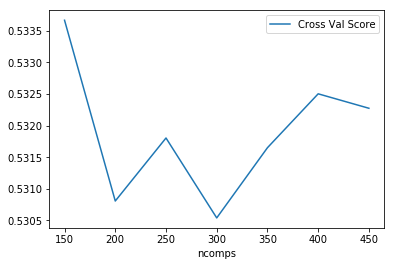

In [21]:
scores_comp = []
for ncomp in range(150,500,50):
    full_pipeline = Pipeline([
        ("preparation", get_vec_pipe(ncomp)),
        ("linear", LinearRegression())
    ])
    scores = cross_val_score(full_pipeline, xtrain, ytrain, scoring="neg_mean_squared_error", cv=3)
    scores_comp.append(pd.Series(np.sqrt(-scores)).mean())

pd.DataFrame({'ncomps':range(150,500,50), "Cross Val Score":scores_comp}).plot(x="ncomps", y="Cross Val Score")

In [31]:
from sklearn.model_selection import GridSearchCV


pipe = get_vec_pipe(ncomp,vect="tfv")
xprepared = pipe.fit_transform(xtrain,ytrain)
param_grid = [
    {'n_estimators': [80,120], 'max_features': [40,60,80]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=2,
                           scoring='neg_mean_squared_error')
grid_search.fit(xprepared, ytrain)

GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [80, 120], 'max_features': [40, 60, 80]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [32]:
grid_search.best_params_

{'max_features': 80, 'n_estimators': 120}

### Results are similar to what we got from Linear Regression. We eliminate testing other algorithms for this brief analysis and continue with linear regression model.  

In [33]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.537963150965 {'max_features': 40, 'n_estimators': 80}
0.536567296252 {'max_features': 40, 'n_estimators': 120}
0.537069968675 {'max_features': 60, 'n_estimators': 80}
0.536147234426 {'max_features': 60, 'n_estimators': 120}
0.536478486347 {'max_features': 80, 'n_estimators': 80}
0.535921141627 {'max_features': 80, 'n_estimators': 120}


## Evaluating final model on test set:
- Results show that final error is similar to what we had form cross validation.

In [36]:
lr = LinearRegression()

xprepared = pipe.fit_transform(xtrain,ytrain)
xtestprep = pipe.transform(xtest)


In [40]:
lr.fit(xprepared, ytrain)
predictions = lr.predict(xtestprep)
lin_mse = mean_squared_error(ytest, predictions)
lin_rmse = np.sqrt(lin_mse)
print('Test Error=',lin_rmse)


Test Error= 0.524906567408
